In [170]:
from scipy.io import wavfile
from scipy.fftpack import dct
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

In [171]:
path = "./Dataset/genres/jazz/jazz.00005.wav"
sr, data = wavfile.read(path)
print(sr)
print(data, data.shape, f"duration (s) = {data.shape[0] / sr}")
duration = 30
sample_num = int(sr*duration)
data = data[:sample_num]
print(data, data.shape, f"duration (s) = {data.shape[0] / sr}")

22050
[2180 5396 7600 ...  110 -213 -237] (661794,) duration (s) = 30.013333333333332
[ 2180  5396  7600 ... -1228 -2685 -4126] (661500,) duration (s) = 30.0


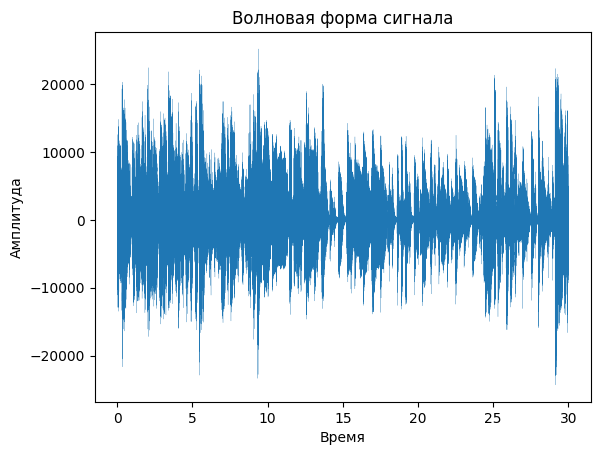

In [172]:
xs = np.arange(0, sample_num, 1) / sr
plt.plot(xs, data, lw=0.15)
plt.xlabel("Время")
plt.ylabel('Амплитуда')
plt.title("Волновая форма сигнала")
plt.show()

### Предварительное выделение (pre-emphasis)

[ 2180.    3957.2   4038.64 ... -1257.7  -1874.52 -2353.9 ] (661500,)


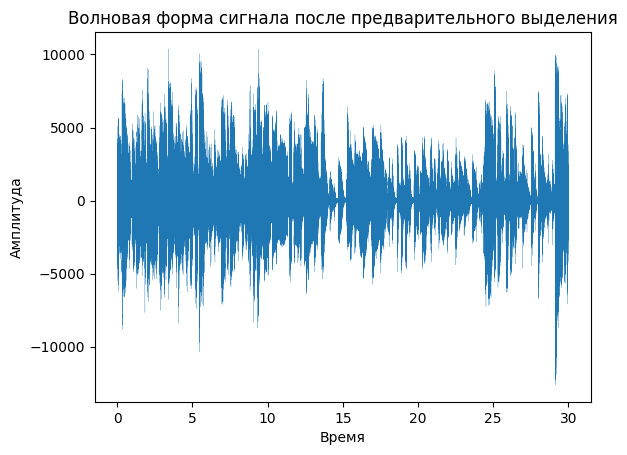

In [173]:
preemp = 0.66
preemp_data = np.append(data[0], data[1:] - preemp * data[:-1])

print(preemp_data, preemp_data.shape)
plt.plot(xs, preemp_data, lw=0.15)
plt.xlabel("Время")
plt.ylabel('Амплитуда')
plt.title("Волновая форма сигнала после предварительного выделения")
plt.show()

### Разбиение на фреймы

In [174]:
def get_frames(data, sr, wlen=0.025, wstep=0.010):
    if wstep > wlen:
        raise Exception("Шаг фрейма больше его длины!")
    flen = round(wlen * sr)
    fstep = round(wstep * sr)

    overflownum = wlen // wstep
    fnum = int(np.ceil(len(data) / fstep))

    frames = np.ndarray((fnum - 1, flen))
    # print(frames.shape)
    for i in range(int(fnum - overflownum)):
        fstart = i * fstep
        frames[i] = data[fstart:fstart+flen]
    last = int(fnum - overflownum)
    last_start = last * fstep
    last_frame = data[last_start:]
    # print(last_frame.shape)
    last_frame = np.append(last_frame, np.zeros(flen - len(last_frame)))
    frames[last] = last_frame
    
    # print(flen, fstep, fnum, frames.shape, frames)
    return frames

In [175]:
framed_data = get_frames(preemp_data, sr)
print(framed_data.shape, framed_data)

(3006, 551) [[ 2180.    3957.2   4038.64 ...  1407.86  1473.48  2059.54]
 [-2457.12 -1656.16 -1680.1  ...    84.5    191.4    373.54]
 [-1310.24  -675.7   -500.08 ... -2368.06 -1967.6  -1349.78]
 ...
 [ 1100.8    616.34   474.34 ...   514.1   -512.88 -1660.5 ]
 [-2715.1   -216.14  2657.64 ...  -710.48  -701.02  -420.52]
 [ 2417.12   793.68  -806.   ...     0.       0.       0.  ]]


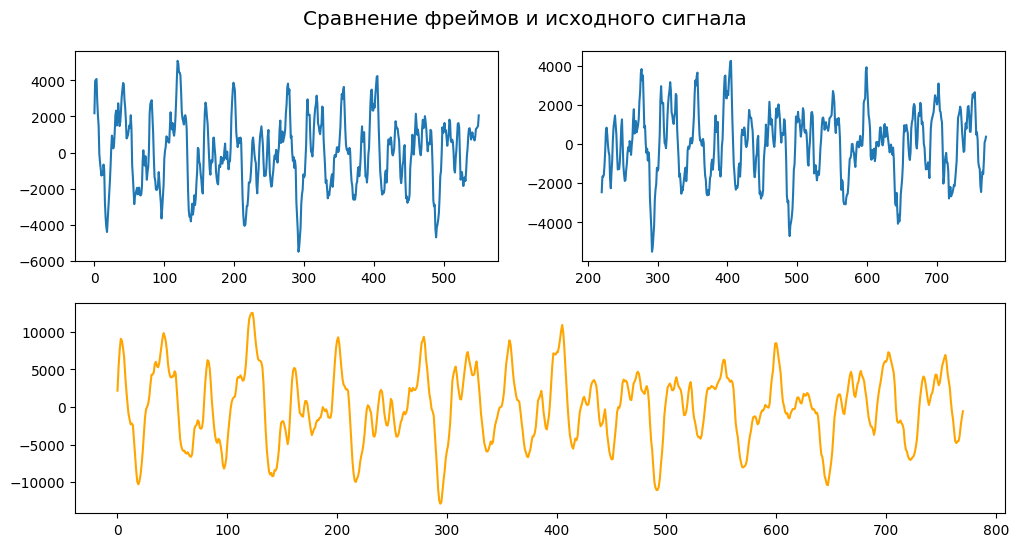

In [176]:
xs = 0.025 + 0.010
flen = framed_data.shape[1]
fstep = int(0.010 * sr)

fig = plt.figure(figsize=(12, 6))
st = fig.suptitle("Сравнение фреймов и исходного сигнала", fontsize="x-large")
st.set_y(0.95)
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax4 = plt.subplot(2,1,2)
ax1.plot(framed_data[0])
ax2.plot(np.arange(fstep, fstep + flen, 1), framed_data[1])
ax4.plot(data[:int(xs * sr)], color='orange')
plt.show()

### Применение оконной функции

In [177]:
def window_Hamming(wlen):
    filter = np.zeros(wlen)
    for n in range(wlen):
        filter[n] = 0.54 - 0.46 * np.cos((2 * np.pi * n) / (wlen - 1))
    return filter

(551,)


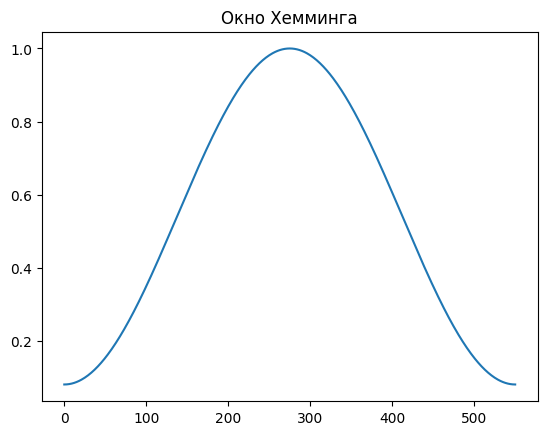

In [178]:
filter = window_Hamming(flen)
print(filter.shape)
plt.plot(filter)
plt.title("Окно Хемминга")
plt.show()

In [179]:
windowed_data = framed_data * filter
print(windowed_data.shape)

(3006, 551)


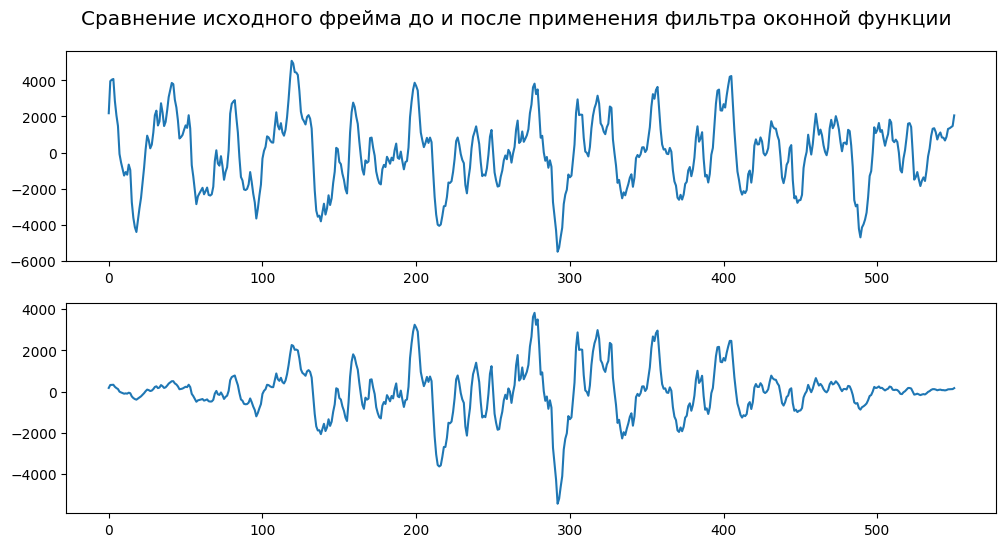

In [180]:
fig = plt.figure(figsize=(12, 6))
st = fig.suptitle("Сравнение исходного фрейма до и после применения фильтра оконной функции", fontsize="x-large")
st.set_y(0.95)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax1.plot(framed_data[0])
ax2.plot(windowed_data[0])
plt.show()

### Дискретное преобразование Фурье

In [181]:
specter = np.abs(fft.rfft(windowed_data))
print(specter.shape)

(3006, 276)


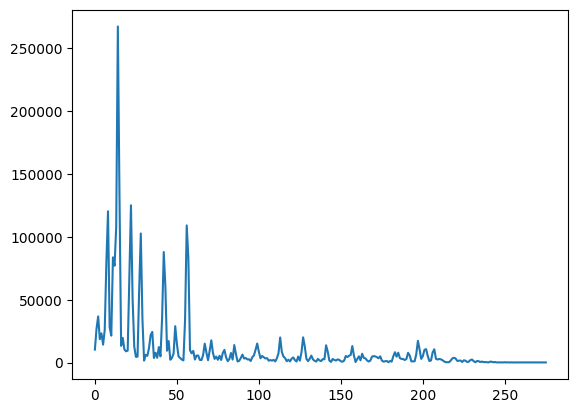

In [182]:
plt.plot(specter[0])
plt.show()

### Построение спектрограммы

In [183]:
def get_spectrogram(data, noise_cutoff=8):
    # spec = np.abs(data)
    spec = data
    spec /= spec.max() # norm
    spec = np.log10(spec)
    spec[spec < -noise_cutoff] = -noise_cutoff

    return spec

In [184]:
spectrogram = get_spectrogram(specter)
print(spectrogram.shape, spectrogram)

(3006, 276) [[-1.99827581 -1.57985855 -1.44603603 ... -4.04151092 -3.98028678
  -4.06667366]
 [-2.70078566 -1.93956918 -2.0086708  ... -3.82600266 -3.86792539
  -3.81883079]
 [-2.62638878 -2.39487167 -1.78755724 ... -5.45789985 -4.84190857
  -5.2348769 ]
 ...
 [-2.01855855 -1.35581897 -0.98932604 ... -3.86712233 -3.90942496
  -3.86924249]
 [-3.37615957 -1.49966363 -1.76087199 ... -3.88528043 -3.91413392
  -3.8699169 ]
 [-1.74678769 -1.31518703 -1.17583367 ... -3.04928412 -3.02995044
  -3.11398785]]


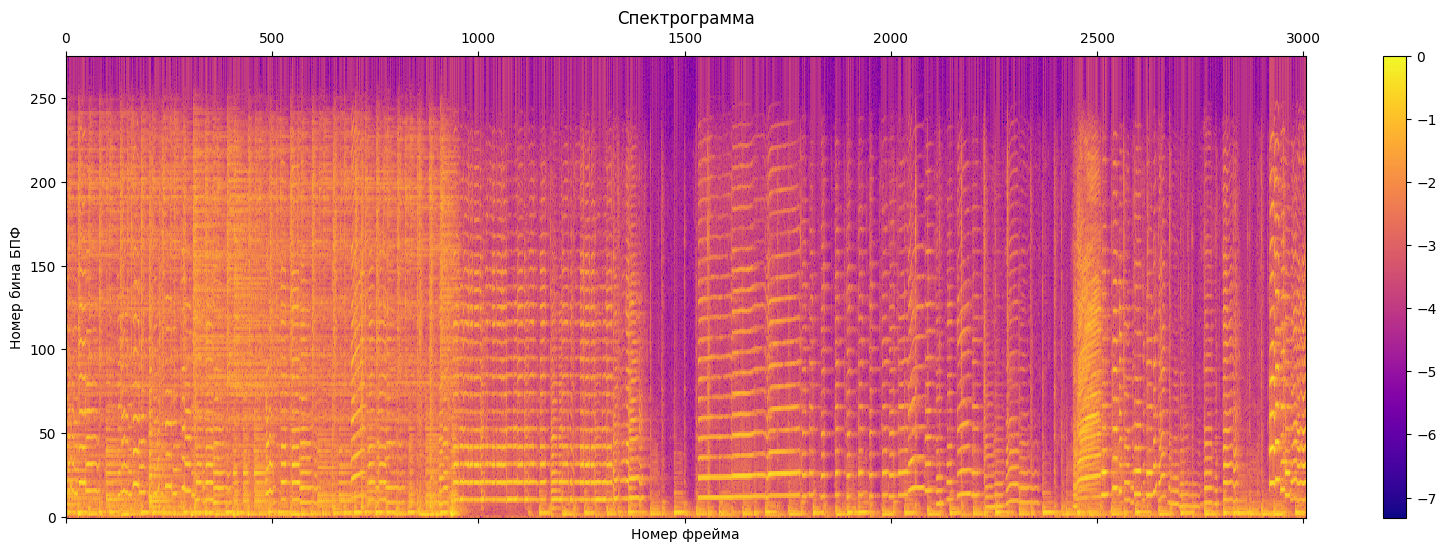

In [185]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
cax = ax.matshow(np.transpose(spectrogram), interpolation="nearest", aspect="auto", cmap=plt.cm.plasma, origin="lower")
fig.colorbar(cax)
plt.xlabel('Номер фрейма')
plt.ylabel('Номер бина БПФ')
plt.title("Спектрограмма")
plt.show()

Частоту в герцах, соответствующую n-ому бину ДПФ, можно получить по формуле n * SR / N, где SR - частота дискретизации, N - размер ДПФ.

### Построение мел-спектрограммы

In [186]:
def hzToMel(hz):
    return 2595 * np.log10(1 + hz / 700.0)

def melToHz(mel):
    return 700 * (10 ** (mel / 2595.0) - 1)

def getFilters(n=32, fsize=276*2, sr=22050):
    lowend = 0
    highend = sr / 2

    lowmel = hzToMel(lowend)
    highmel = hzToMel(highend)
    melspace = np.linspace(lowmel, highmel, n+2)
    print(melspace[0:-1:len(melspace)//2-1])
    hzspace = np.array(list(map(melToHz, melspace)))
    print(hzspace[0:-1:len(melspace)//2-1])

    bins = np.floor((fsize+1) * melToHz(melspace) / sr)
    print(bins)

    filters = np.zeros([n, fsize // 2])
    for j in range(0, n):
        for i in range(int(bins[j]), int(bins[j + 1])):
            filters[j, i] = (i - bins[j]) / (bins[j + 1] - bins[j])
        for i in range(int(bins[j + 1]), int(bins[j + 2])):
            filters[j, i] = (bins[j + 2] - i) / (bins[j + 2] - bins[j + 1])
    return filters, hzspace

[   0.         1540.03318085 3080.06636171]
[    0.          2045.11009406 10065.18489789]
[  0.   1.   3.   5.   7.   9.  11.  14.  17.  20.  23.  27.  31.  35.
  40.  45.  51.  57.  64.  71.  79.  87.  97. 107. 118. 130. 144. 158.
 174. 191. 210. 230. 252. 276.]


Text(0.5, 1.0, 'матрица мел-фильтра')

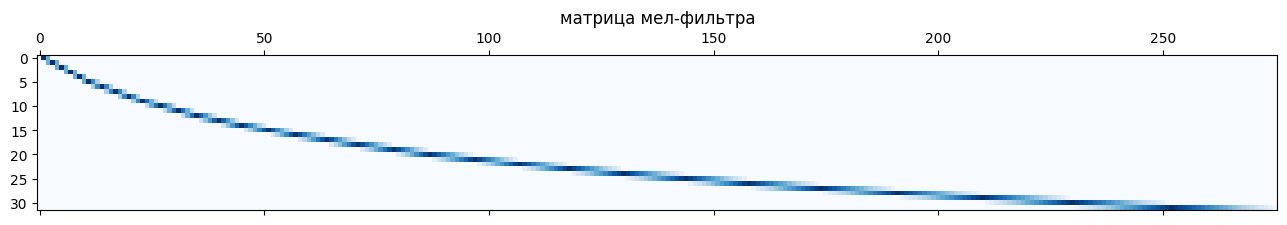

In [187]:
filterMatrix, hzspace = getFilters()

plt.matshow(filterMatrix, cmap=plt.cm.Blues, interpolation="nearest", aspect="auto")
plt.title("матрица мел-фильтра")

Text(0.5, 1.0, 'нормализованная матрица мел-фильтра')

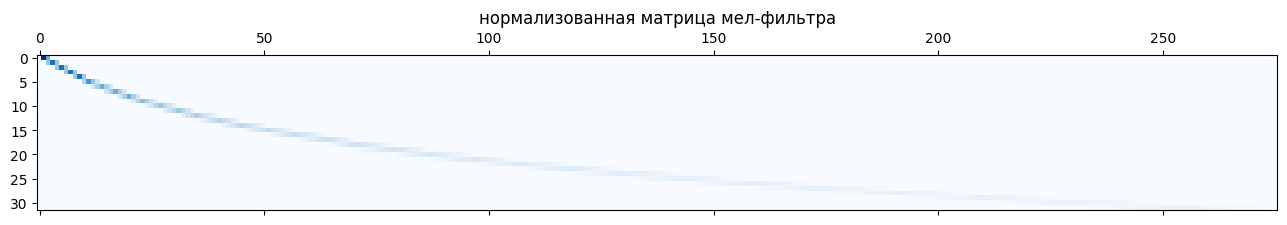

In [188]:
filter_sums = filterMatrix.sum(axis=1)
filter_sums[filter_sums == 0] = 1e-8
normFilterMatrix = filterMatrix.T / filter_sums
plt.matshow(np.transpose(normFilterMatrix), cmap=plt.cm.Blues, interpolation="nearest", aspect="auto")
plt.title("нормализованная матрица мел-фильтра")

In [189]:
melSpectrogram = np.transpose(normFilterMatrix).dot(np.transpose(spectrogram))
melSpectrogram.shape

(32, 3006)

Text(0.5, 1.0, 'мел-спектрограмма')

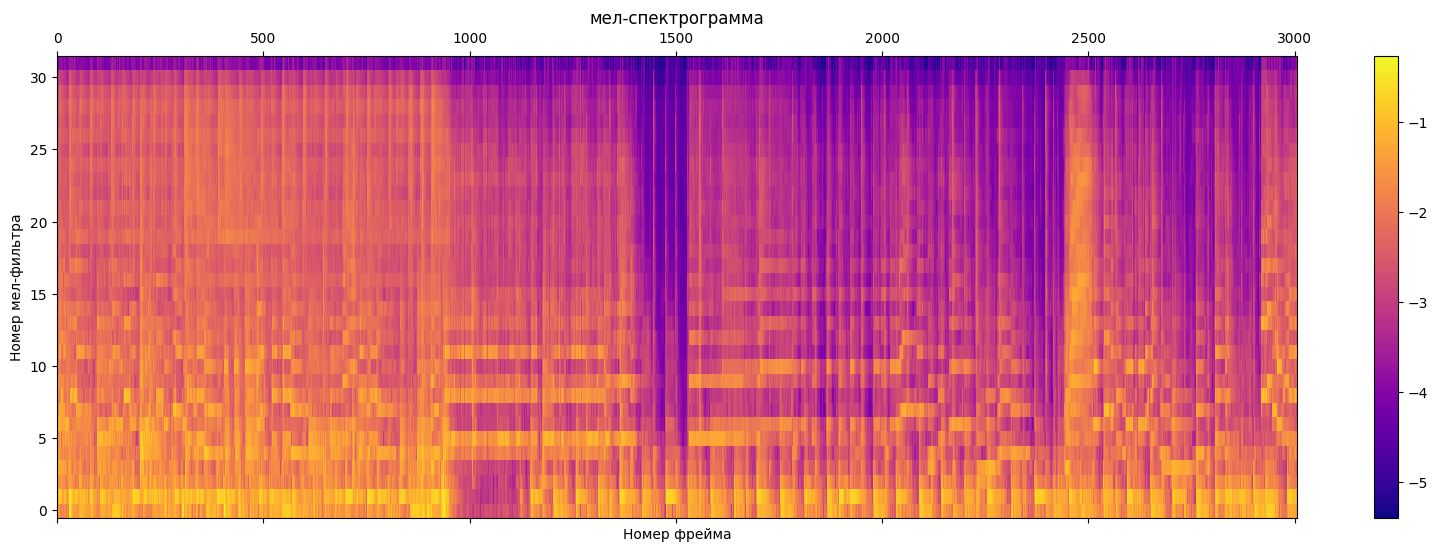

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
cax = ax.matshow(melSpectrogram.astype("float32"), interpolation="nearest", aspect="auto", cmap=plt.cm.plasma, origin="lower")
fig.colorbar(cax)
plt.xlabel('Номер фрейма')
plt.ylabel('Номер мел-фильтра')
plt.title("мел-спектрограмма")

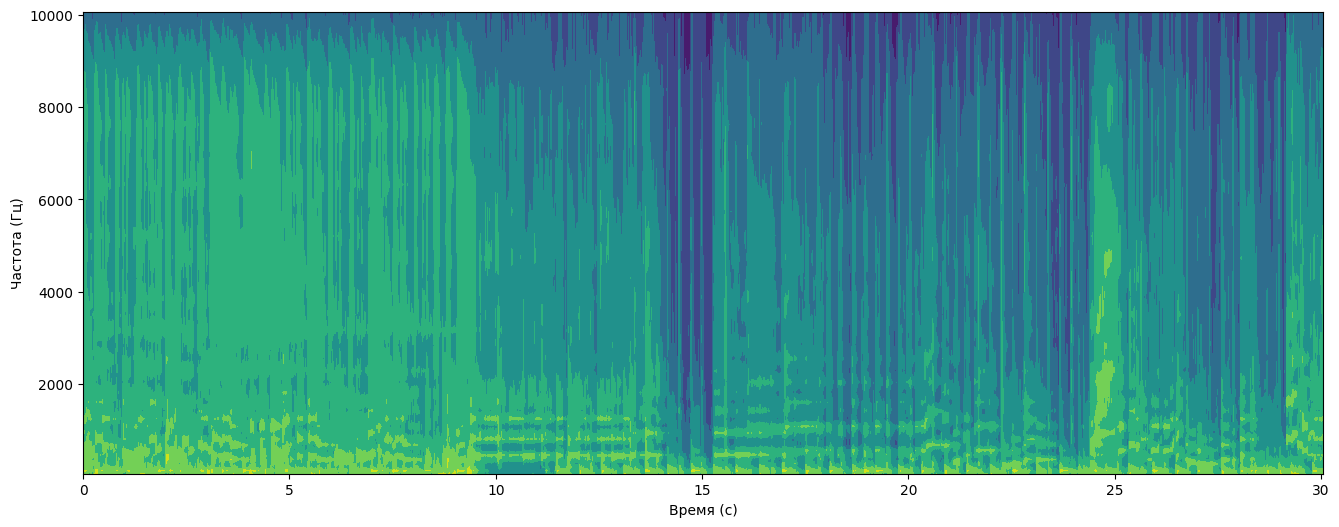

In [191]:
times = np.arange(0, melSpectrogram.shape[1], 1) * 0.010

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
cax = plt.contourf(times, hzspace[1:33], melSpectrogram)
ax.set_xlabel('Время (с)')
ax.set_ylabel('Частота (Гц)')
plt.show()


### Построение MFCC

In [192]:
numToKeep = 16
mfcc = dct(melSpectrogram.T, type=2, axis=1, norm='ortho')[:, : numToKeep]
print(mfcc.shape)
print(mfcc[0])

(3006, 16)
[-12.00452453   3.01366607  -0.23751173   0.23944699  -0.58114992
   0.07567588  -0.79687183   0.15925447  -0.32712519   0.41614321
  -0.30607919   0.39748762  -0.03292323   0.36032033  -0.0608355
   0.08832419]


Text(0.5, 1.0, 'MFCC')

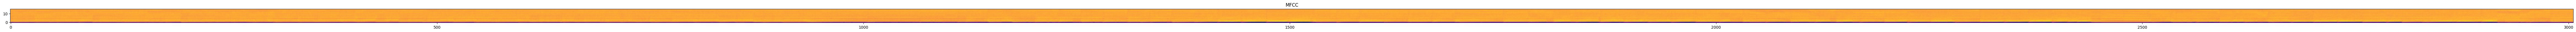

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(120, 60))
cax = ax.imshow(mfcc.T, cmap=plt.cm.plasma, origin="lower")
plt.title("MFCC")

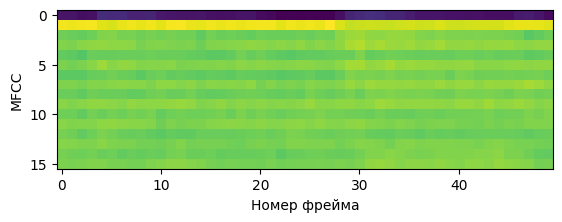

In [194]:
plt.imshow(mfcc[0:50].T, interpolation='antialiased')
plt.xlabel('Номер фрейма')
plt.ylabel('MFCC')
plt.show()